WORK IN PROGRESS

# Initialization

Imports.\

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from suffix_tree import Tree

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, unix_timestamp , to_timestamp, regexp_replace, expr, trim
from pyspark.sql.types import LongType

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize

from collections import Counter

import math


In [ ]:
dbname = ''
user = ''
password = ''
host = ''
port = 

connection_string = f"postgresql+psycopg2://{user}:{password}@/{dbname}"
engine = create_engine(connection_string)

In [5]:
jdbc_driver_path = "/data2/petit/code/drivers/postgresql-42.7.3.jar"
data_path = "/data2/petit/data/twitter"

spark = SparkSession.builder \
    .appName("Spark SQL basic example") \
    .config("spark.driver.memory", "30g") \
    .config("spark.executor.memory", "190g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.jars", jdbc_driver_path) \
    .getOrCreate()

print("Spark UI available at http://localhost:4040")

# set timeparser to legacy to avoid errors when converting timestamps
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

25/05/05 11:15:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 11:15:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark UI available at http://localhost:4040


DataFrame[key: string, value: string]

# Transform Data

In [6]:
write_path = "/data2/petit/data/processed/cresci/"
if not os.path.exists(write_path):
    os.makedirs(write_path)

LCS_path = "/data2/petit/data/processed/cresci/lcs/"
if not os.path.exists(LCS_path):
    os.makedirs(LCS_path)

sample_path = "/data2/petit/data/processed/cresci/sample/"
if not os.path.exists(sample_path):
    os.makedirs(sample_path)

## Twibot 20

In [7]:
tb20_path = "/data2/petit/data/twitter/Twibot-20/"

In [49]:
# Tweets, users and labels

df_tweets = spark.read \
    .option("multiLine", True) \
    .json(tb20_path + "node.json") \
    .filter("id like 't%'") \
    .select("id", "text") \
    .withColumnRenamed("id", "tweet_id") \
    .withColumn("is_retweet", when(col("text").startswith("RT"), 1).otherwise(0))\
    .persist()

df_edges = spark.read \
    .option("multiLine", True) \
    .csv(tb20_path + "edge.csv", header=True) \
    .filter("relation = 'post'") \
    .select("source_id", "target_id")\
    .withColumnRenamed("source_id", "user_id") \
    .withColumnRenamed("target_id", "tweet_id") \
    .persist()

df_labels = spark.read \
    .option("multiLine", True) \
    .csv(tb20_path + "label.csv", header=True) \
    .withColumnRenamed("id", "user_id") \
    .persist()


# Extract the DNA of the users

df_type = df_edges.join(df_tweets, on="tweet_id", how="inner")\
    .select("user_id", "tweet_id", "is_retweet")\
    .withColumn("tweet_id", regexp_replace(col("tweet_id"), "t", ""))\
    .withColumn("tweet_id", col("tweet_id").cast("int"))\
    .orderBy(col("tweet_id"))\
    .groupBy("user_id")\
    .agg({"is_retweet": "collect_list"})\
    .withColumnRenamed("collect_list(is_retweet)", "is_retweet")\
    .withColumn("DNA", expr("concat_ws('', transform(is_retweet, x -> CASE WHEN x = 0 THEN 'A' ELSE 'T' END))"))\
    .select("user_id", "DNA")\
    .join(df_labels, on="user_id", how="inner")\
    .persist()

25/04/30 15:12:04 WARN CacheManager: Asked to cache already cached data.        
25/04/30 15:12:04 WARN CacheManager: Asked to cache already cached data.
25/04/30 15:12:04 WARN CacheManager: Asked to cache already cached data.
25/04/30 15:12:05 WARN CacheManager: Asked to cache already cached data.


In [ ]:
df_type.show(5)
if not os.path.exists(write_path + "DNA"):
    os.makedirs(write_path + "DNA")
df_type.toPandas().to_csv(write_path + "DNA/twibot20_DNA.csv", index=False)

+--------------------+--------------------+-----+
|             user_id|                 DNA|label|
+--------------------+--------------------+-----+
|u1006654104662228993|                AAAA|human|
|          u103208086|AAAAATAAAAAAAATAA...|  bot|
|         u1063034450|TAAAAAAAAAAAAAATA...|human|
|u1068999598801412101|            TTTAATTA|  bot|
|u1096681893364256769|AAAAAAAAAAATAATAT...|  bot|
+--------------------+--------------------+-----+
only showing top 5 rows



## Twibot 22

In [4]:
tb22_path = "/data2/petit/data/twitter/Twibot-22/"

In [ ]:
write_path = "/data2/petit/data/processed/cresci/"

if not os.path.exists(write_path + "edges"):
    os.makedirs(write_path + "edges")

for i in range(0,9):
    spark.read.option("multiLine", True).json(tb22_path + "tweet_" + str(i) + ".json") \
        .select("created_at", "id", "author_id", "in_reply_to_user_id", "text")\
        .withColumn("is_retweet", when(col("text").startswith("RT"), 1).otherwise(0))\
        .withColumn("is_reply", when(col("in_reply_to_user_id").isNull(), 0).otherwise(1))\
        .select("created_at", "id", "author_id", "is_retweet", "is_reply")\
        .withColumnRenamed("id", "tweet_id")\
        .withColumnRenamed("author_id", "user_id")\
        .coalesce(1)\
        .write.csv(write_path + "edges/" + str(i), header=True, mode="overwrite")

In [ ]:
# Load the edges and labels

df_edges = spark.read.option("header", "true").csv(write_path + "edges/*")\
    .withColumnRenamed("id", "tweet_id")\
    .withColumnRenamed("author_id", "user_id")\
    .withColumnRenamed("created_at", "created_at")\
    .withColumn("is_retweet", col("is_retweet").cast("int"))\
    .withColumn("is_reply", col("is_reply").cast("int"))\
    .persist()

df_labels = spark.read \
    .option("multiLine", True) \
    .csv(tb22_path + "label.csv", header=True) \
    .withColumnRenamed("id", "user_id") \
    .withColumn("user_id", regexp_replace(col("user_id"), "u", ""))\
    .persist()

# Extract the DNA of the users

df_type = df_edges.withColumn("tweet_id", regexp_replace(col("tweet_id"), "t", ""))\
    .withColumn("tweet_id", col("tweet_id").cast("long"))\
    .withColumn("DNA", when(col("is_retweet") == 1, "T").when(col("is_reply") == 1, "C").otherwise("A"))\
    .orderBy(col("tweet_id"))\
    .groupBy("user_id")\
    .agg({"DNA": "collect_list"})\
    .withColumnRenamed("collect_list(DNA)", "DNA")\
    .withColumn("DNA", expr("concat_ws('', DNA)"))\
    .join(df_labels, on="user_id", how="inner")\
    .persist()

In [63]:
# Write the DNA to a file

if not os.path.exists(write_path + "DNA"):
    os.makedirs(write_path + "DNA")
df_type.toPandas().to_csv(write_path + "DNA/twibot22_DNA.csv", index=False)

## Cresci 2015

In [94]:
cr15_path = "/data2/petit/data/twitter/cresci-2015/"
subdirs = ["E13", "TFP", "FSF", "INT", "TWT"]
human_dirs = ["E13", "TFP"]
bot_dirs = ["FSF", "INT", "TWT"]

In [165]:
# load tweets (split bots and humans)

df_tweets_humans = None
for subdir in human_dirs:
    df = spark.read.option("header", "true").csv(cr15_path + subdir + "/tweets.csv")\
        .select("id", "text", "user_id", "in_reply_to_user_id")\
        .persist()
    if df_tweets_humans is None:
        df_tweets_humans = df
    else:
        df_tweets_humans = df_tweets_humans.union(df)

df_tweets_bots = None
for subdir in bot_dirs:
    df = spark.read.option("header", "true").csv(cr15_path + subdir + "/tweets.csv")\
        .select("id", "text", "user_id", "in_reply_to_user_id")\
        .persist()
    if df_tweets_bots is None:
        df_tweets_bots = df
    else:
        df_tweets_bots = df_tweets_bots.union(df)

25/05/02 14:11:23 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:23 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:23 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:23 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:23 WARN CacheManager: Asked to cache already cached data.


In [166]:
# load users (split bots and humans)

df_users_humans = None
for subdir in human_dirs:
    df = spark.read.option("header", "true").csv(cr15_path + subdir + "/users.csv")\
        .select("id")\
        .withColumnRenamed("id", "user_id")\
        .persist()
    if df_users_humans is None:
        df_users_humans = df
    else:
        df_users_humans = df_users_humans.union(df)

df_users_bots = None
for subdir in bot_dirs:
    df = spark.read.option("header", "true").csv(cr15_path + subdir + "/users.csv")\
        .select("id")\
        .withColumnRenamed("id", "user_id")\
        .persist()
    if df_users_bots is None:
        df_users_bots = df
    else:
        df_users_bots = df_users_bots.union(df)

25/05/02 14:11:24 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:24 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:24 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:24 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:11:24 WARN CacheManager: Asked to cache already cached data.


In [168]:
# Get the DNA of the users and add the label

df_tweets_humans = df_tweets_humans.join(df_users_humans, on="user_id", how="inner")\
    .withColumn("is_retweet", when(col("text").startswith("RT"), 1).otherwise(0))\
    .withColumn("is_reply", when(col("in_reply_to_user_id") == 0, 0).otherwise(1))\
    .withColumnRenamed("id", "tweet_id")\
    .withColumn("DNA", when(col("is_retweet") == 1, "T").when(col("is_reply") == 1, "C").otherwise("A"))\
    .withColumn("tweet_id", col("tweet_id").cast("long"))\
    .orderBy(col("tweet_id"))\
    .groupBy("user_id")\
    .agg({"DNA": "collect_list"})\
    .withColumnRenamed("collect_list(DNA)", "DNA")\
    .withColumn("DNA", expr("concat_ws('', DNA)"))\
    .withColumn("label", expr("'human'"))\
    .persist()

df_tweets_bots = df_tweets_bots.join(df_users_bots, on="user_id", how="inner")\
    .withColumn("is_retweet", when(col("text").startswith("RT"), 1).otherwise(0))\
    .withColumn("is_reply", when(col("in_reply_to_user_id") == 0, 0).otherwise(1))\
    .withColumnRenamed("id", "tweet_id")\
    .withColumn("DNA", when(col("is_retweet") == 1, "T").when(col("is_reply") == 1, "C").otherwise("A"))\
    .withColumn("tweet_id", col("tweet_id").cast("long"))\
    .orderBy(col("tweet_id"))\
    .groupBy("user_id")\
    .agg({"DNA": "collect_list"})\
    .withColumnRenamed("collect_list(DNA)", "DNA")\
    .withColumn("DNA", expr("concat_ws('', DNA)"))\
    .withColumn("label", expr("'bot'"))\
    .persist()

25/05/02 14:12:11 WARN CacheManager: Asked to cache already cached data.
25/05/02 14:12:11 WARN CacheManager: Asked to cache already cached data.


In [169]:
# union the two dataframes and write to file
df_tweets = df_tweets_humans.union(df_tweets_bots)\
    .persist()

# Write the DNA to a file
if not os.path.exists(write_path + "DNA"):
    os.makedirs(write_path + "DNA")

df_tweets.toPandas().to_csv(write_path + "DNA/cresci2015_DNA.csv", index=False)

## Cresci 2017

In [171]:
cr17_path = "/data2/petit/data/twitter/cresci-2017/"
subdirs = ["genuine_accounts", "social_spambots_1", "social_spambots_2", "social_spambots_3"]
human_dirs = ["genuine_accounts"]
bot_dirs = ["social_spambots_1", "social_spambots_2", "social_spambots_3"]

In [172]:
# load tweets (split bots and humans)

df_tweets_humans = None
for subdir in human_dirs:
    df = spark.read.option("header", "true").csv(cr17_path + subdir + "/tweets.csv")\
        .select("id", "text", "user_id", "in_reply_to_user_id")\
        .persist()
    if df_tweets_humans is None:
        df_tweets_humans = df
    else:
        df_tweets_humans = df_tweets_humans.union(df)

df_tweets_bots = None
for subdir in bot_dirs:
    df = spark.read.option("header", "true").csv(cr17_path + subdir + "/tweets.csv")\
        .select("id", "text", "user_id", "in_reply_to_user_id")\
        .persist()
    if df_tweets_bots is None:
        df_tweets_bots = df
    else:
        df_tweets_bots = df_tweets_bots.union(df)

In [173]:
# load users (split bots and humans)

df_users_humans = None
for subdir in human_dirs:
    df = spark.read.option("header", "true").csv(cr17_path + subdir + "/users.csv")\
        .select("id")\
        .withColumnRenamed("id", "user_id")\
        .persist()
    if df_users_humans is None:
        df_users_humans = df
    else:
        df_users_humans = df_users_humans.union(df)

df_users_bots = None
for subdir in bot_dirs:
    df = spark.read.option("header", "true").csv(cr17_path + subdir + "/users.csv")\
        .select("id")\
        .withColumnRenamed("id", "user_id")\
        .persist()
    if df_users_bots is None:
        df_users_bots = df
    else:
        df_users_bots = df_users_bots.union(df)

In [174]:
# Get the DNA of the users and add the label

df_tweets_humans = df_tweets_humans.join(df_users_humans, on="user_id", how="inner")\
    .withColumn("is_retweet", when(col("text").startswith("RT"), 1).otherwise(0))\
    .withColumn("is_reply", when(col("in_reply_to_user_id") == 0, 0).otherwise(1))\
    .withColumnRenamed("id", "tweet_id")\
    .withColumn("DNA", when(col("is_retweet") == 1, "T").when(col("is_reply") == 1, "C").otherwise("A"))\
    .withColumn("tweet_id", col("tweet_id").cast("long"))\
    .orderBy(col("tweet_id"))\
    .groupBy("user_id")\
    .agg({"DNA": "collect_list"})\
    .withColumnRenamed("collect_list(DNA)", "DNA")\
    .withColumn("DNA", expr("concat_ws('', DNA)"))\
    .withColumn("label", expr("'human'"))\
    .persist()

df_tweets_bots = df_tweets_bots.join(df_users_bots, on="user_id", how="inner")\
    .withColumn("is_retweet", when(col("text").startswith("RT"), 1).otherwise(0))\
    .withColumn("is_reply", when(col("in_reply_to_user_id") == 0, 0).otherwise(1))\
    .withColumnRenamed("id", "tweet_id")\
    .withColumn("DNA", when(col("is_retweet") == 1, "T").when(col("is_reply") == 1, "C").otherwise("A"))\
    .withColumn("tweet_id", col("tweet_id").cast("long"))\
    .orderBy(col("tweet_id"))\
    .groupBy("user_id")\
    .agg({"DNA": "collect_list"})\
    .withColumnRenamed("collect_list(DNA)", "DNA")\
    .withColumn("DNA", expr("concat_ws('', DNA)"))\
    .withColumn("label", expr("'bot'"))\
    .persist()

In [176]:
# union the two dataframes and write to file
df_tweets = df_tweets_humans.union(df_tweets_bots)\
    .persist()

# Write the DNA to a file
if not os.path.exists(write_path + "DNA"):
    os.makedirs(write_path + "DNA")

df_tweets.toPandas().to_csv(write_path + "DNA/cresci2017_DNA.csv", index=False)

# LCS processing

In [132]:
def split(df, prop_bot, balancing=True, notest=False):
    max = 1500
    df_bot = df[df['label'] == 1]
    df_human = df[df['label'] == 0]

    if balancing:
        nb_bots = len(df_bot)
        nb_humans = len(df_human)
        if nb_humans > max:
            nb_humans = max
        if nb_bots > max:
            nb_bots = max

        sample_nb_humans = min(nb_bots / prop_bot, nb_humans)
        sample_nb_bots = sample_nb_humans * prop_bot
        
        if sample_nb_bots < 5:
            sample_nb_bots = 5
        if sample_nb_humans < 5:
            sample_nb_humans = 5
        
        df_bot = df_bot.sample(int(sample_nb_bots))
        df_human = df_human.sample(int(sample_nb_humans))
        df = pd.concat([df_bot, df_human])
    else:
        df = df.sample(max * 2)
    
    df_train, df_test = train_test_split(df, test_size=0.5)

    if notest:
        df_train = df
        # df test in empty
        df_test = pd.DataFrame(columns=df.columns)

    return df_train, df_test

In [ ]:
def lcs(dfdna):
    dna_dic = {}
    for index, row in dfdna.iterrows():
        dna_dic[row["user_id"]] = row["DNA"]

    output_dataframe = pd.DataFrame(columns=["k", "length", "path"])
    try:
        tree = Tree(dna_dic)
        
        for k, length, path in tree.common_substrings():
            path = str(path).replace(" ", "")
            output_dataframe = pd.concat([output_dataframe, pd.DataFrame({"k": [k], "length": [length], "path": [path]})], ignore_index=True)
    except Exception as e:
        print("Erreur pendant le calcul du suffix tree (LCS):" + str(e))

    return output_dataframe

In [150]:
# We are iterating on files and on bot proportions
files = ["cresci2015_DNA.csv", "cresci2017_DNA.csv", "twibot20_DNA.csv", "twibot22_DNA.csv"]
datasets = ["cresci2015", "cresci2017", "twibot20", "twibot22"]
botprops = [1/1, 1/4, 1/9, 1/19, 1/99, 0]
botpromname = ["50", "20", "10", "5", "1", "nobalance"]


for file, dataset in zip(files, datasets):
    df = pd.read_csv(write_path + "DNA/" + file, sep=",")
    df['label'] = df['label'].apply(lambda x: 1 if x == 'bot' else 0)
    df["DNA"] = df["DNA"].str[:500]

    # make a subdirectory for each dataset with the name of the dataset. both in LCS_path and sample_path
    if not os.path.exists(LCS_path + dataset):
        os.makedirs(LCS_path + dataset)
    if not os.path.exists(sample_path + dataset):
        os.makedirs(sample_path + dataset)

    for botprop, botpropname in zip(botprops, botpromname):
        print("Processing dataset: " + dataset + " with botprop: " + botpropname)

        if botprop != 0:
            train,test = split(df, botprop, True, notest=False)
        else:
            train,test = split(df, 1, False, notest=False)
        lcs_train = lcs(train)
        lcs_test = lcs(test)
        
        # write the lcs_train and lcs_test to files
        lcs_train.to_csv(LCS_path + dataset + "/" + dataset + "_train_" + botpropname + ".csv", index=False)
        lcs_test.to_csv(LCS_path + dataset + "/" + dataset + "_test_" + botpropname + ".csv", index=False)

        # write the train and test to files
        train.to_csv(sample_path + dataset + "/" + dataset + "_train_" + botpropname + ".csv", index=False)
        test.to_csv(sample_path + dataset + "/" + dataset + "_test_" + botpropname + ".csv", index=False)

Processing dataset: cresci2015 with botprop: 50
Processing dataset: cresci2015 with botprop: 20
Processing dataset: cresci2015 with botprop: 10
Processing dataset: cresci2015 with botprop: 5
Processing dataset: cresci2015 with botprop: 1
Processing dataset: cresci2015 with botprop: nobalance
Processing dataset: cresci2017 with botprop: 50
Processing dataset: cresci2017 with botprop: 20
Processing dataset: cresci2017 with botprop: 10
Processing dataset: cresci2017 with botprop: 5
Processing dataset: cresci2017 with botprop: 1
Processing dataset: cresci2017 with botprop: nobalance
Processing dataset: twibot20 with botprop: 50
Processing dataset: twibot20 with botprop: 20
Processing dataset: twibot20 with botprop: 10
Processing dataset: twibot20 with botprop: 5
Processing dataset: twibot20 with botprop: 1
Processing dataset: twibot20 with botprop: nobalance
Processing dataset: twibot22 with botprop: 50
Processing dataset: twibot22 with botprop: 20
Processing dataset: twibot22 with botprop

Calcul du plus long Longest Common Substring associé à chaque utilisateur de chaque jeu de données

In [ ]:
def longest_lcs(df_sample,df_lcs):
    # add a column to df_sample with the longest lcs
    df_sample['longest_lcs'] = 0

    for i, row in df_sample.iterrows():
        user_dna = row["DNA"]
        for _,row in df_lcs.iterrows():
            if str(row['path']) in str(user_dna):
                df_sample.at[i, 'longest_lcs'] = row['length']
                break

In [ ]:
for file, dataset in zip(files, datasets):
    for botprop, botpropname in zip(botprops, botpromname):
        print("Processing dataset: " + dataset + " with botprop: " + botpropname)
        df_train = pd.read_csv(sample_path + dataset + "/" + dataset + "_train_" + botpropname + ".csv", sep=",")
        df_test = pd.read_csv(sample_path + dataset + "/" + dataset + "_test_" + botpropname + ".csv", sep=",")
        df_lcs_train = pd.read_csv(LCS_path + dataset + "/" + dataset + "_train_" + botpropname + ".csv", sep=",")
        df_lcs_test = pd.read_csv(LCS_path + dataset + "/" + dataset + "_test_" + botpropname + ".csv", sep=",")

        longest_lcs(df_train,df_lcs_train)
        longest_lcs(df_test,df_lcs_test)

        # write the train and test to files
        df_train.to_csv(sample_path + dataset + "/" + dataset + "_train_" + botpropname + ".csv", index=False)
        df_test.to_csv(sample_path + dataset + "/" + dataset + "_test_" + botpropname + ".csv", index=False)

Processing dataset: cresci2015 with botprop: 50
Processing dataset: cresci2015 with botprop: 20
Processing dataset: cresci2015 with botprop: 10
Processing dataset: cresci2015 with botprop: 5
Processing dataset: cresci2015 with botprop: 1
Processing dataset: cresci2015 with botprop: nobalance
Processing dataset: cresci2017 with botprop: 50
Processing dataset: cresci2017 with botprop: 20
Processing dataset: cresci2017 with botprop: 10
Processing dataset: cresci2017 with botprop: 5
Processing dataset: cresci2017 with botprop: 1
Processing dataset: cresci2017 with botprop: nobalance
Processing dataset: twibot20 with botprop: 50
Processing dataset: twibot20 with botprop: 20
Processing dataset: twibot20 with botprop: 10
Processing dataset: twibot20 with botprop: 5
Processing dataset: twibot20 with botprop: 1
Processing dataset: twibot20 with botprop: nobalance
Processing dataset: twibot22 with botprop: 50
Processing dataset: twibot22 with botprop: 20
Processing dataset: twibot22 with botprop

# Model

In [8]:
class Report:
    def __init__(self, accuracy, precision, recall, specificity, f1, mcc, roc_auc):
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.specificity = specificity
        self.f1 = f1
        self.mcc = mcc
        self.roc_auc = roc_auc

    def __str__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"

    def __repr__(self):
        return f"Accuracy: {self.accuracy:.4f}\nPrecision: {self.precision:.4f}\nRecall: {self.recall:.4f}\nSpecificity: {self.specificity:.4f}\nF1: {self.f1:.4f}\nMCC: {self.mcc:.4f}\nAUC: {self.roc_auc:.4f}"


def train(train_dna_dataframe, max_k):
    X_train = train_dna_dataframe['longest_lcs']
    y_train = train_dna_dataframe['label']

    mcc_lst = []

    for k in range(2,max_k+1):
        y_pred = X_train < k
        y_pred = y_pred.apply(lambda x: 0 if x else 1)
        mcc_lst.append(matthews_corrcoef(y_train, y_pred))

    best_k = np.argmax(mcc_lst) + 2
    return best_k

def unsupervised_bestk(lcs_train_dataframe):
    y_list = lcs_train_dataframe['length'].tolist()
    derivatives = np.gradient(y_list)
    return np.argmin(derivatives)+2

def test(test_dna_dataframe, best_k):
    X_test = test_dna_dataframe['longest_lcs']
    y_test = test_dna_dataframe['label']

    y_pred = X_test < best_k
    y_pred = y_pred.apply(lambda x: 0 if x else 1)

    report = Report(
        accuracy=accuracy_score(y_test, y_pred),
        precision=precision_score(y_test, y_pred),
        recall=recall_score(y_test, y_pred),
        specificity=recall_score(y_test, y_pred, pos_label=0),
        f1=f1_score(y_test, y_pred),
        mcc=matthews_corrcoef(y_test, y_pred),
        roc_auc=roc_auc_score(y_test, y_pred)
    )
    return report

# TRAINING and TESTING on the same dataset

### Framework

In [9]:
files = ["cresci2015_DNA.csv", "cresci2017_DNA.csv", "twibot20_DNA.csv", "twibot22_DNA.csv"]
datasets = ["cresci2015", "cresci2017", "twibot20", "twibot22"]
botprops = [1/1, 1/4, 1/9, 1/19, 1/99, 0]
botpromname = ["50", "20", "10", "5", "1", "nobalance"]

In [ ]:
def run_tests(prop_bot_index):
    # rappel des prop_box_index : 0 = 50%, 1 = 20%, 2 = 10%, 3 = 5%, 4 = 1%, 5 = nobalance
    os.makedirs('./results/cresci_supervised', exist_ok=True)
    os.makedirs('./results/cresci_unsupervised', exist_ok=True)

    df_results_supervised = pd.DataFrame(columns=["dataset", "accuracy", "precision", "recall", "specificity", "f1", "mcc", "roc_auc"])
    df_results_unsupervised = pd.DataFrame(columns=["dataset", "accuracy", "precision", "recall", "specificity", "f1", "mcc", "roc_auc"])

    for file, dataset in zip(files, datasets):
        print("Processing dataset: " + dataset + " with botprop: " + botpromname[prop_bot_index])
        df_train = pd.read_csv(sample_path + dataset + "/" + dataset + "_train_" + botpromname[prop_bot_index] + ".csv", sep=",")
        df_test = pd.read_csv(sample_path + dataset + "/" + dataset + "_test_" + botpromname[prop_bot_index] + ".csv", sep=",")
        df_lcs_test = pd.read_csv(LCS_path + dataset + "/" + dataset + "_test_" + botpromname[prop_bot_index] + ".csv", sep=",")

        best_k_supervised = train(df_train, 100)
        best_k_unsupervised = unsupervised_bestk(df_lcs_test)
        
        report_supervised = test(df_test, best_k_supervised)
        report_unsupervised = test(df_test, best_k_unsupervised)

        df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
        df_results_unsupervised = pd.concat([df_results_unsupervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_unsupervised.accuracy], "precision": [report_unsupervised.precision], "recall": [report_unsupervised.recall], "specificity": [report_unsupervised.specificity], "f1": [report_unsupervised.f1], "mcc": [report_unsupervised.mcc], "roc_auc": [report_unsupervised.roc_auc]})], ignore_index=True)

    return df_results_supervised, df_results_unsupervised

def save_results(df_results_supervised, df_results_unsupervised, prop_bot_index):
    df_results_supervised.to_csv('./results/cresci_supervised/results_' + botpromname[prop_bot_index] + '.csv', index=False)
    df_results_unsupervised.to_csv('./results/cresci_unsupervised/results_' + botpromname[prop_bot_index] + '.csv', index=False)


In [281]:
# on test avec 50% de bots
df_sup, df_unsup = run_tests(0)
print("Supervised results for 50% of bots:")
print(df_sup)
print("Unsupervised results for 50% of bots:")
print(df_unsup)

Processing dataset: cresci2015 with botprop: 50


/tmp/ipykernel_942952/1141655415.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_942952/1141655415.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: 50
Processing dataset: twibot20 with botprop: 50
Processing dataset: twibot22 with botprop: 50
Supervised results for 50% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.644000   0.630597  0.681452     0.607143  0.655039  0.289336   
1  cresci2017  0.612188   0.891566  0.269091     0.966229  0.413408  0.326561   
2    twibot20  0.508000   0.489011  0.121253     0.878590  0.194323 -0.000240   
3    twibot22  0.501333   0.495370  0.143432     0.855438  0.222453 -0.001610   

    roc_auc  
0  0.644297  
1  0.617660  
2  0.499922  
3  0.499435  
Unsupervised results for 50% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.482000   0.487640  0.875000     0.095238  0.626263 -0.047558   
1  cresci2017  0.603878   0.816754  0.283636     0.934334  0.421053  0.285919   
2    twibot20  0.494000   0.451362  0.158038     0.815927  0.234107

### 50/50

3 repetitions, average and std for all datasets without favourite count column

Balanced dataset (bots:humans = 1:1)

In [ ]:
df_sup, df_unsup = run_tests(0)

print("Supervised results for 50% of bots:")
print(df_sup)

print("Unsupervised results for 50% of bots:")
print(df_unsup)

save_results(df_sup, df_unsup, 0)

Processing dataset: cresci2015 with botprop: 50


/tmp/ipykernel_990834/4290436752.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_990834/4290436752.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: 50
Processing dataset: twibot20 with botprop: 50
Processing dataset: twibot22 with botprop: 50
Supervised results for 50% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.644000   0.630597  0.681452     0.607143  0.655039  0.289336   
1  cresci2017  0.612188   0.891566  0.269091     0.966229  0.413408  0.326561   
2    twibot20  0.508000   0.489011  0.121253     0.878590  0.194323 -0.000240   
3    twibot22  0.501333   0.495370  0.143432     0.855438  0.222453 -0.001610   

    roc_auc  
0  0.644297  
1  0.617660  
2  0.499922  
3  0.499435  
Unsupervised results for 50% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.482000   0.487640  0.875000     0.095238  0.626263 -0.047558   
1  cresci2017  0.603878   0.816754  0.283636     0.934334  0.421053  0.285919   
2    twibot20  0.494000   0.451362  0.158038     0.815927  0.234107

### 20/80

3 repetitions, average and std for all datasets without favourite count column

Unbalanced dataset (bots:humans = 1:4 = 20%/80%)

In [ ]:
df_sup, df_unsup = run_tests(1)

print("Supervised results for 20% of bots:")
print(df_sup)
print("Unsupervised results for 20% of bots:")
print(df_unsup)

save_results(df_sup, df_unsup, 1)

Processing dataset: cresci2015 with botprop: 20


/tmp/ipykernel_990834/4290436752.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_990834/4290436752.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: 20
Processing dataset: twibot20 with botprop: 20
Processing dataset: twibot22 with botprop: 20
Supervised results for 20% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.646055   0.312661  0.647059     0.645806  0.421603  0.237671   
1  cresci2017  0.837518   0.639344  0.307087     0.960000  0.414894  0.364150   
2    twibot20  0.714286   0.180451  0.131148     0.855629  0.151899 -0.015022   
3    twibot22  0.662047   0.205607  0.230366     0.772423  0.217284  0.002677   

    roc_auc  
0  0.646432  
1  0.633543  
2  0.493388  
3  0.501395  
Unsupervised results for 20% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.197228   0.191721  0.941176     0.011984  0.318552 -0.129544   
1  cresci2017  0.617430   0.253731  0.535433     0.636364  0.344304  0.137142   
2    twibot20  0.675906   0.169399  0.169399     0.798675  0.169399

### 10/90

In [ ]:
df_sup, df_unsup = run_tests(2)

print("Supervised results for 10% of bots:")
print(df_sup)
print("Unsupervised results for 10% of bots:")
print(df_unsup)

save_results(df_sup, df_unsup, 2)   

Processing dataset: cresci2015 with botprop: 10


/tmp/ipykernel_990834/4290436752.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_990834/4290436752.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: 10
Processing dataset: twibot20 with botprop: 10
Processing dataset: twibot22 with botprop: 10
Supervised results for 10% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.654262   0.165079  0.675325     0.652116  0.265306  0.195578   
1  cresci2017  0.901993   0.500000  0.254237     0.972376  0.337079  0.309636   
2    twibot20  0.769508   0.072000  0.105882     0.844920  0.085714 -0.041700   
3    twibot22  0.777911   0.109375  0.164706     0.847594  0.131455  0.010324   

    roc_auc  
0  0.663721  
1  0.613306  
2  0.475401  
3  0.506150  
Unsupervised results for 10% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.134454   0.087179  0.883117     0.058201  0.158693 -0.069635   
1  cresci2017  0.146179   0.097345  0.932203     0.060773  0.176282 -0.008694   
2    twibot20  0.662665   0.070175  0.188235     0.716578  0.102236

### 5/95

In [13]:
df_sup, df_unsup = run_tests(3)

print("Supervised results for 5% of bots:")
print(df_sup)
print("Unsupervised results for 5% of bots:")  
print(df_unsup)

save_results(df_sup, df_unsup, 3)

Processing dataset: cresci2015 with botprop: 5


/tmp/ipykernel_990834/4290436752.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_990834/4290436752.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: 5
Processing dataset: twibot20 with botprop: 5
Processing dataset: twibot22 with botprop: 5
Supervised results for 5% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.641318   0.093333  0.717949     0.637333  0.165192  0.158643   
1  cresci2017  0.933333   0.392857  0.343750     0.968401  0.366667  0.332470   
2    twibot20  0.840304   0.051020  0.131579     0.876165  0.073529  0.005027   
3    twibot22  0.695817   0.065502  0.365854     0.713904  0.111111  0.039003   

    roc_auc  
0  0.677641  
1  0.656076  
2  0.503872  
3  0.539879  
Unsupervised results for 5% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.059569   0.047619  0.948718     0.013333  0.090686 -0.067214   
1  cresci2017  0.233333   0.060738  0.875000     0.195167  0.113590  0.041071   
2    twibot20  0.730038   0.051282  0.263158     0.753662  0.085837  0.0

### 1/99

In [15]:
df_sup, df_unsup = run_tests(4)

print("Supervised results for 1% of bots:")
print(df_sup)
print("Unsupervised results for 1% of bots:")
print(df_unsup)

save_results(df_sup, df_unsup, 4)

Processing dataset: cresci2015 with botprop: 1


/tmp/ipykernel_990834/4290436752.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_990834/4290436752.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: 1
Processing dataset: twibot20 with botprop: 1
Processing dataset: twibot22 with botprop: 1
Supervised results for 1% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.875989   0.000000  0.000000     0.882979  0.000000 -0.032372   
1  cresci2017  0.895795   0.036364  0.333333     0.902033  0.065574  0.081518   
2    twibot20  0.705805   0.004566  0.166667     0.710106  0.008889 -0.024092   
3    twibot22  0.907652   0.000000  0.000000     0.917333  0.000000 -0.030825   

    roc_auc  
0  0.441489  
1  0.617683  
2  0.438387  
3  0.458667  
Unsupervised results for 1% of bots:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.027704   0.008075  1.000000     0.019947  0.016021  0.012692   
1  cresci2017  0.076782   0.011742  1.000000     0.066543  0.023211  0.027952   
2    twibot20  0.650396   0.003831  0.166667     0.654255  0.007491 -0.0

### No Balancing

In [16]:
df_sup, df_unsup = run_tests(5)

print("Supervised results for no balance:")
print(df_sup)
print("Unsupervised results for no balance:")
print(df_unsup)

save_results(df_sup, df_unsup, 5)

Processing dataset: cresci2015 with botprop: nobalance


/tmp/ipykernel_990834/4290436752.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_supervised = pd.concat([df_results_supervised, pd.DataFrame({"dataset": [dataset], "accuracy": [report_supervised.accuracy], "precision": [report_supervised.precision], "recall": [report_supervised.recall], "specificity": [report_supervised.specificity], "f1": [report_supervised.f1], "mcc": [report_supervised.mcc], "roc_auc": [report_supervised.roc_auc]})], ignore_index=True)
/tmp/ipykernel_990834/4290436752.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

Processing dataset: cresci2017 with botprop: nobalance
Processing dataset: twibot20 with botprop: nobalance
Processing dataset: twibot22 with botprop: nobalance
Supervised results for no balance:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.678667   0.757403  0.711991     0.623675  0.733996  0.330253   
1  cresci2017  0.378667   0.965714  0.268680     0.950413  0.420398  0.190544   
2    twibot20  0.435333   0.518519  0.114754     0.859133  0.187919 -0.038964   
3    twibot22  0.742000   0.154639  0.241935     0.812785  0.188679  0.045609   

    roc_auc  
0  0.667833  
1  0.609547  
2  0.486944  
3  0.527360  
Unsupervised results for no balance:
      dataset  accuracy  precision    recall  specificity        f1       mcc  \
0  cresci2015  0.612000   0.646912  0.829764     0.252650  0.727017  0.099622   
1  cresci2017  0.374667   0.967836  0.263116     0.954545  0.413750  0.190837   
2    twibot20  0.434667   0.519481  0.093677    

# Generalization

For each dataset, a model is trained on it, and tested on the rest

### Layout

In [ ]:
def train_test_on_all(bot_prop, filename, legend):

    # TRAIN ON ALL, TEST ON ALL

    df_results = pd.DataFrame(index=datasets, columns=datasets)

    for file, dataset in zip(files, datasets):
        print("Processing dataset: " + dataset + " with botprop: " + botpromname[bot_prop])
        df_train = pd.read_csv(sample_path + dataset + "/" + dataset + "_train_" + botpromname[bot_prop] + ".csv", sep=",")
        best_k = train(df_train, 100)

        for file, dataset_test in zip(files, datasets):
            df_test = pd.read_csv(sample_path + dataset_test + "/" + dataset_test + "_test_" + botpromname[bot_prop] + ".csv", sep=",")
            df_lcs_test = pd.read_csv(LCS_path + dataset_test + "/" + dataset_test + "_test_" + botpromname[bot_prop] + ".csv", sep=",")
            report = test(df_test, best_k)
            df_results.at[dataset, dataset_test] = report.mcc


    # to normalize MCC, we add 1 first to avoid negative values
    #df_results_normalized = df_results.add(1)
    #df_results_normalized = df_results.div(df_results.max(axis=1), axis=0)
    #df_results_normalized = df_results_normalized.apply(pd.to_numeric)
    df_results_normalized = df_results.apply(pd.to_numeric)


    # PLOT

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_results_normalized, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'MCC'}, annot_kws={'size': 18}, vmin=-1, vmax=1)
    plt.title(legend)
    plt.xlabel("Test Datasets")
    plt.ylabel("Train Datasets")
    plt.tight_layout()
    plt.show()


    # SAVE TO CSV



### Balanced (50/50)

Processing dataset: cresci2015 with botprop: 50
Processing dataset: cresci2017 with botprop: 50
Processing dataset: twibot20 with botprop: 50
Processing dataset: twibot22 with botprop: 50


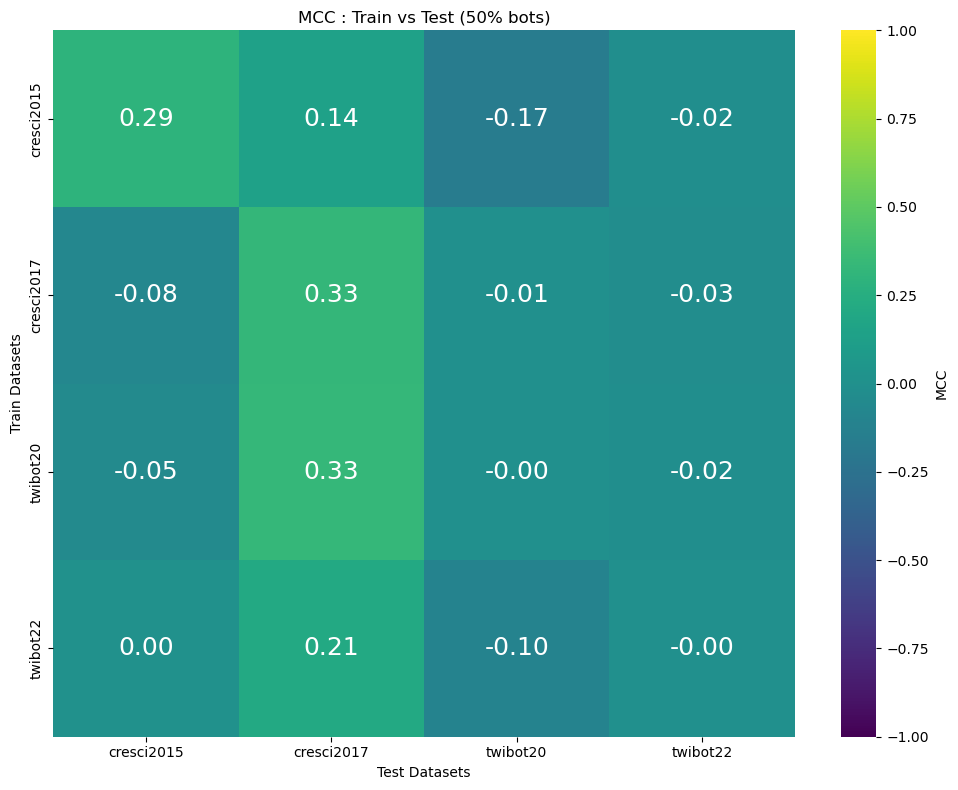

In [20]:
train_test_on_all(0, "results_50.csv", "MCC : Train vs Test (50% bots)")

### 20/80

Processing dataset: cresci2015 with botprop: 20
Processing dataset: cresci2017 with botprop: 20
Processing dataset: twibot20 with botprop: 20
Processing dataset: twibot22 with botprop: 20


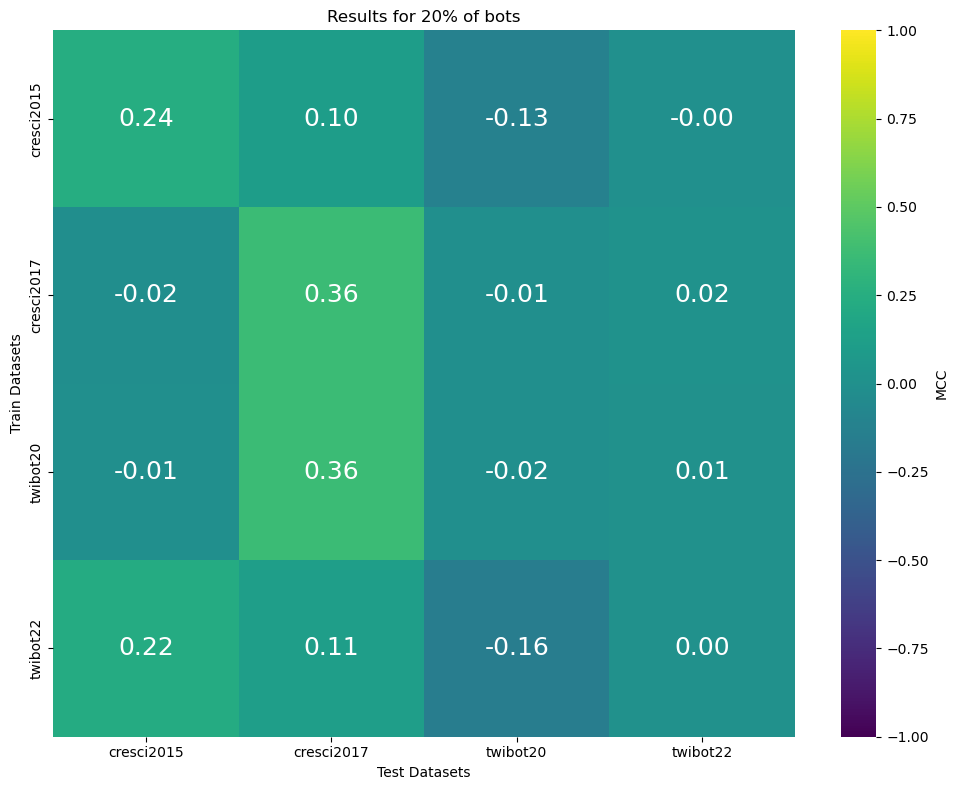

In [11]:
train_test_on_all(1, "results_20.csv", "Results for 20% of bots")

### 10/90

Processing dataset: cresci2015 with botprop: 10
Processing dataset: cresci2017 with botprop: 10
Processing dataset: twibot20 with botprop: 10
Processing dataset: twibot22 with botprop: 10


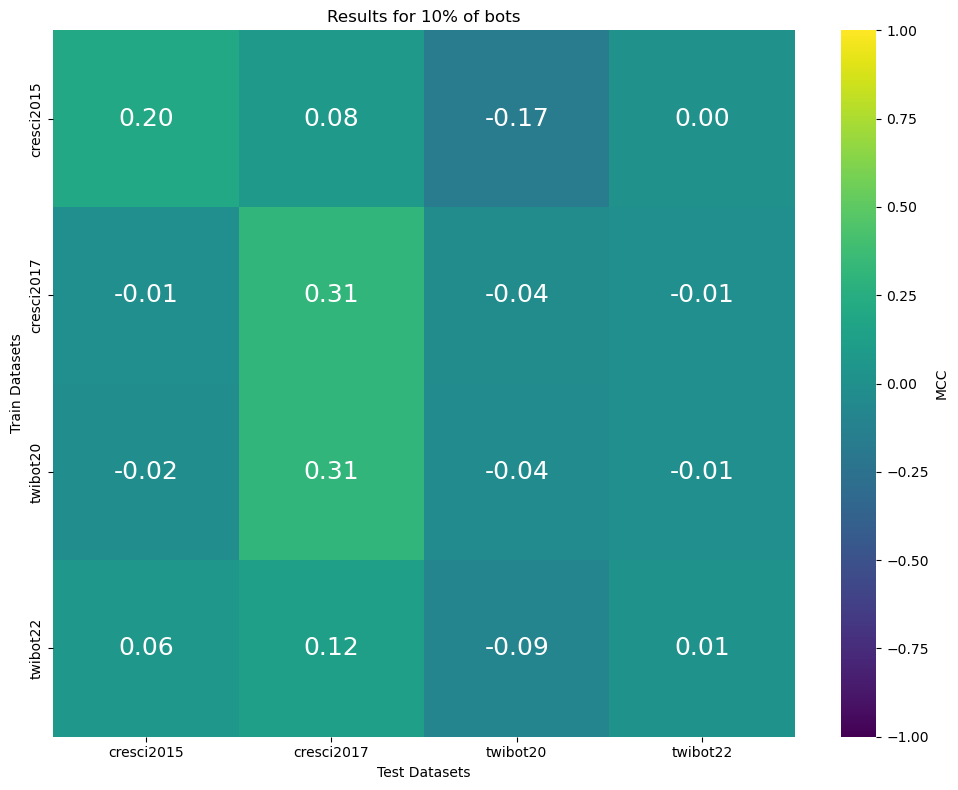

In [12]:
train_test_on_all(2, "results_10.csv", "Results for 10% of bots")

### 5/95

Processing dataset: cresci2015 with botprop: 5
Processing dataset: cresci2017 with botprop: 5
Processing dataset: twibot20 with botprop: 5
Processing dataset: twibot22 with botprop: 5


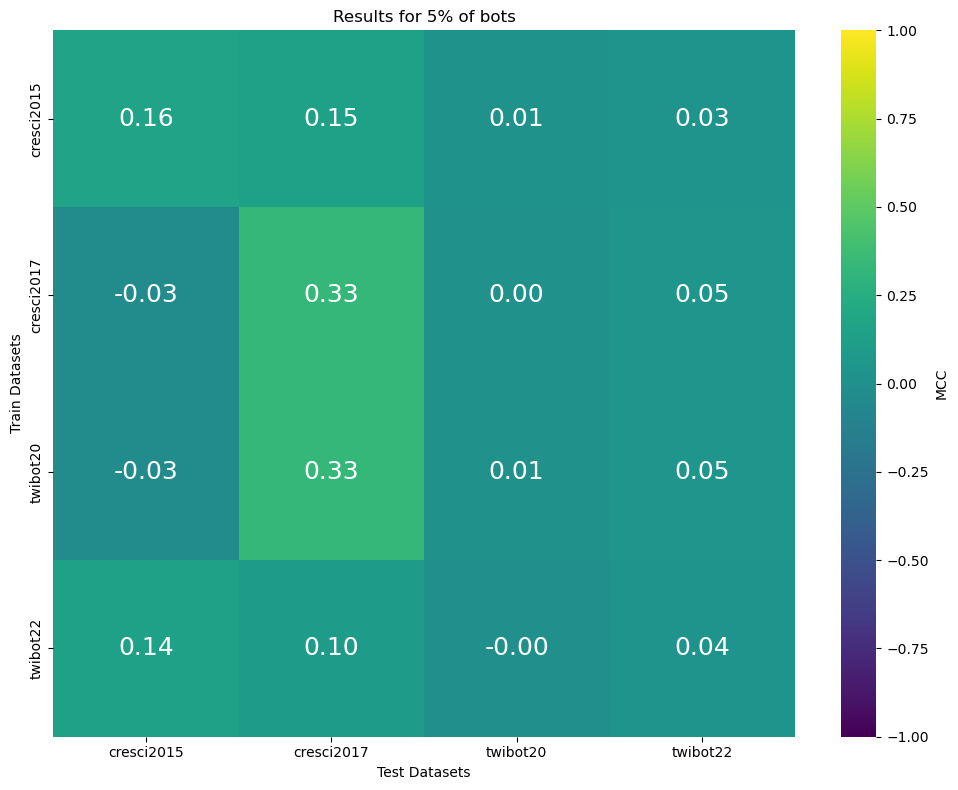

In [18]:
train_test_on_all(3, "results_5.csv", "Results for 5% of bots")

### 1/99

Processing dataset: cresci2015 with botprop: 1
Processing dataset: cresci2017 with botprop: 1
Processing dataset: twibot20 with botprop: 1
Processing dataset: twibot22 with botprop: 1


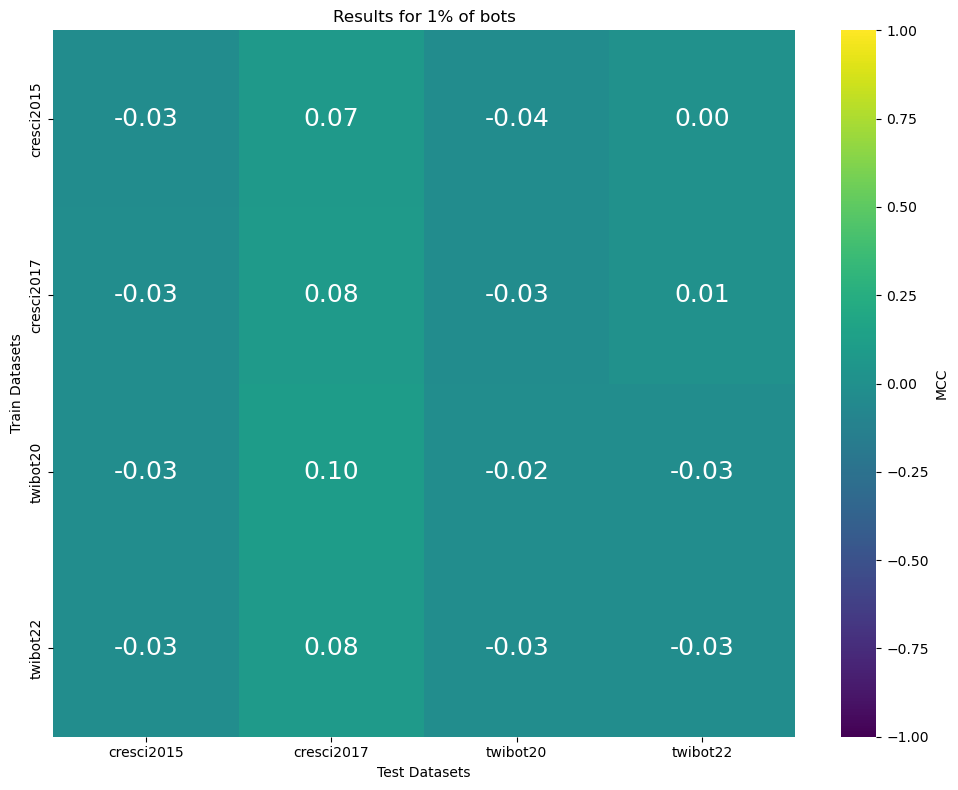

In [17]:
train_test_on_all(4, "results_1.csv", "Results for 1% of bots")

### No balancing

Processing dataset: cresci2015 with botprop: nobalance
Processing dataset: cresci2017 with botprop: nobalance
Processing dataset: twibot20 with botprop: nobalance
Processing dataset: twibot22 with botprop: nobalance


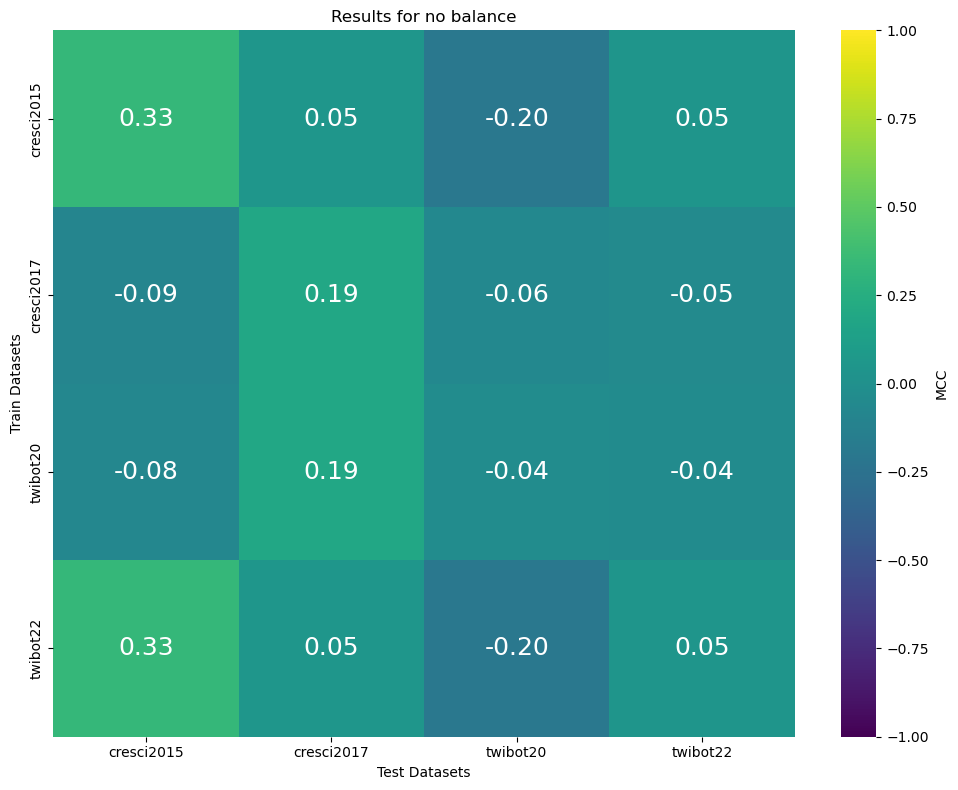

In [ ]:
train_test_on_all(5, "MCC : Train vs Test (No sampling)", "Results for no balance")